In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import pickle
import time



##### set parent directory

In [2]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# Move to the parent directory
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

# Print the updated working directory
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Current Directory: /mnt/c/users/rjmay/code/research_ms/alt_distr
Updated Directory: /mnt/c/users/rjmay/code/research_ms


### Simulation stage

In [3]:
from modules.multi_bounds_v3 import bounds_class
from modules.Bhatt_knn_func import knn_num_calc
from modules.data_gen import data_gen

In [4]:
PICKLED =True

In [5]:
file_path = 'sim_data/uniform_normal.pkl' # DONT FORGET TO CHANGE ME IF YOU COPY AND PASTE


# if PICKLED  == False:
    
#     objects_to_save = bound_obj_lst


#     with open(file_path, 'wb') as file:
#         # Use pickle.dump to serialize and write the list of objects to the file
#         pickle.dump(objects_to_save, file)
#     print(f'Objects saved to {file_path}')
    

if PICKLED == True:


    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    bound_obj_lst = loaded_objects

Loaded object successfully


### Using the data

may or not be pickled. 

In [6]:
dp_l = []
dp_u = []

Bha_u =[]
Bha_l =[]

Bha_knn_u = []
Bha_knn_l = []

inf_l = []
inf_u = []

enDive_l = []
enDive_u = []


for obj in bound_obj_lst:
    a,b = obj.get_bounds_dp()
    dp_l.append(a)
    dp_u.append(b)
    
    a,b = obj.get_bounds_Bha()
    Bha_l.append(a)
    Bha_u.append(b)

    
#     a, b = obj.get_bounds_tight()
#     tight_l.append(a)
#     tight_u.append(b)
    
    a, b= obj.get_bounds_Bha_knn()
    Bha_knn_l.append(a)
    Bha_knn_u.append(b)
    
    a,b = obj.get_inf_bounds()
    inf_l.append(a)
    inf_u.append(b)
    
    a,b = obj.get_Bounds_enDive()
    enDive_l.append(a)
    enDive_u.append(b)
    
    

Calculate true values

In [7]:
import numpy as np
# import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import uniform
#### I have to code the true values and theoreticals. 

# Define dx and x range
dx = 0.001
x = np.arange(-10, 10 + dx, dx)

# Define the normal distributions
f0 = norm.pdf(x, loc=0, scale=1) ## this might be wonk
pd1 = uniform(loc=0.5, scale=2.5)  #0 to 3
f1 = pd1.pdf(x)

# Calculate the minimum of f0 and f1
min_f0_f1 = np.minimum(f0, f1)
# Calculate BER as 0.5 * sum(min(f0, f1) * dx)
BER = 0.5 * np.nansum(min_f0_f1 * dx)

p = 0.5
q = 0.5
pf0 = p * f0
qf1 = q * f1

# Calculate the function
func = (pf0 - qf1)**2 / (pf0 + qf1)

# Calculate dp using numerical integration (sum and dx)
dp = np.nansum(func) * dx

# Calculate upper and lower bounds
upper = 0.5 - 0.5 * dp
lower = 0.5 - 0.5 * np.sqrt(dp)

theory_Dp = [lower, upper]

func2 = np.sqrt(f0 * f1)
# Calculate BC using numerical integration (sum and dx)
BC = np.nansum(func2) * dx

lower = 0.5 - 0.5 * np.sqrt(1 - BC**2)
upper = 0.5 * BC

theory_bha = [lower, upper]


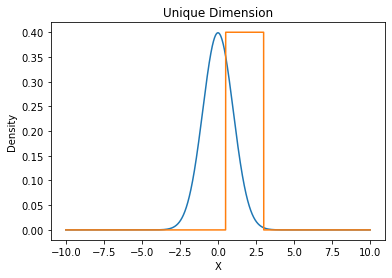

In [8]:
plt.plot(x, f0)
plt.plot(x, f1)
plt.title("Unique Dimension")
plt.xlabel("X")
plt.ylabel("Density")
plt.show()

In [9]:
BER

0.15350691875939732

In [10]:
theory_Dp

[0.11498553211861606, 0.20352771904402955]

True value is     0.1536


In [11]:
### this cell helps to fix bugs from not doing the data in here. 
MC_num = len(bound_obj_lst[0])

BER_lst = np.ones(MC_num) * BER

sample_sizes = np.logspace(2, 3.3011, 9 , endpoint = True, dtype = int)


def mse(l1, l2):## numpy lists
    return ((l1 - l2)**2).mean(axis=0)

In [12]:
cases = len(sample_sizes)

## theoretical MSE
bha_theoretical_l= np.ones(MC_num) * (theory_bha[0])
bha_theoretical_u= np.ones(MC_num) * (theory_bha[1])


dp_theoretical_l= np.ones(MC_num) * theory_Dp[0]
dp_theoretical_u= np.ones(MC_num) * theory_Dp[1]


In [13]:
def mse_v2(true, matrix):
    temp = matrix - true
    temp = temp **2
    return np.mean(temp, axis= 1)
    

### Plotting

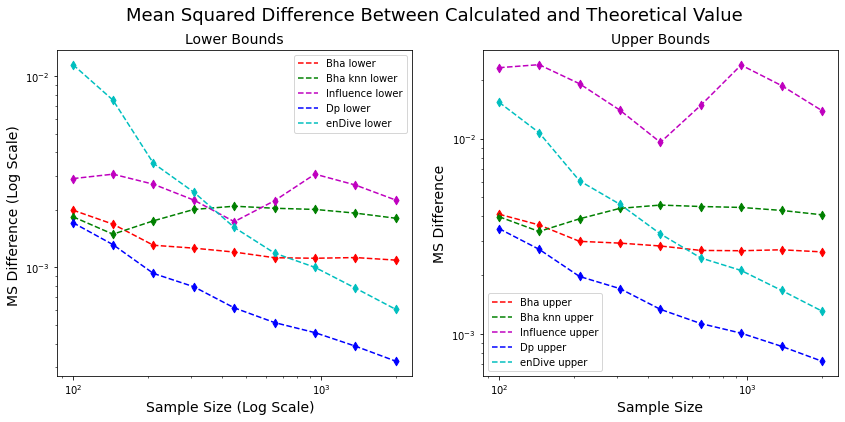

In [14]:
lower_mse_DP =mse_v2(theory_Dp[0], dp_l)
upper_mse_DP = mse_v2(theory_Dp[1], dp_u)

lower_mse_Bha = mse_v2(theory_bha[0], Bha_l)
upper_mse_Bha =mse_v2(theory_bha[1], Bha_u)


lower_mse_Bha_knn = mse_v2(theory_bha[0], Bha_knn_l)
upper_mse_Bha_knn =mse_v2(theory_bha[1], Bha_knn_u)

lower_mse_inf = mse_v2(theory_bha[0], inf_l)
upper_mse_inf = mse_v2(theory_bha[1], inf_u)

lower_mse_enDive = mse_v2(theory_Dp[0], enDive_l)
upper_mse_enDive = mse_v2(theory_Dp[1], enDive_u)


fs =14

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
st = fig.suptitle("Mean Squared Difference Between Calculated and Theoretical Value", fontsize=fs+4)
ax = axes[0]


ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, lower_mse_Bha,'r--', label='Bha lower')
ax.scatter(sample_sizes, lower_mse_Bha, color = 'red', marker = 'd')

ax.plot(sample_sizes, lower_mse_Bha_knn, color = 'green',linestyle="--",  label = "Bha knn lower")
ax.scatter(sample_sizes, lower_mse_Bha_knn, color = 'g', marker = 'd')

ax.plot(sample_sizes, lower_mse_inf,  'm--', label='Influence lower')
ax.scatter(sample_sizes, lower_mse_inf,  color='m', marker='d')

ax.plot(sample_sizes, lower_mse_DP,  'b--', label='Dp lower')
ax.scatter(sample_sizes, lower_mse_DP,  color='b', marker='d')


ax.plot(sample_sizes, lower_mse_enDive,  'c--', label='enDive lower')
ax.scatter(sample_sizes, lower_mse_enDive,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale) ", fontsize=fs)
ax.set_title("Lower Bounds", fontsize = fs)



ax.legend()

ax = axes[1]

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, upper_mse_Bha,'r--', label='Bha upper')
ax.scatter(sample_sizes, upper_mse_Bha, color = 'red', marker = 'd')


ax.plot(sample_sizes, upper_mse_Bha_knn, color = 'g',  linestyle  = "--", label = "Bha knn upper")
ax.scatter(sample_sizes, upper_mse_Bha_knn, color = 'g', marker = 'd')

ax.plot(sample_sizes, upper_mse_inf,  'm--', label='Influence upper')
ax.scatter(sample_sizes, upper_mse_inf,  color='m', marker='d')


ax.plot(sample_sizes, upper_mse_DP,  'b--', label='Dp upper')
ax.scatter(sample_sizes, upper_mse_DP,  color='b', marker='d')


ax.plot(sample_sizes, upper_mse_enDive,  'c--', label='enDive upper')
ax.scatter(sample_sizes, upper_mse_enDive,  color='c', marker='d')

ax.set_xlabel("Sample Size", fontsize = fs)
ax.set_ylabel("MS Difference", fontsize=fs)
ax.set_title("Upper Bounds", fontsize = fs)

ax.legend()

# plt.savefig("log_test.png",facecolor=(1,1,1,1))
# ax.set_xticks(sample_sizes)

file_name = r"alt_distr/images/uniform_normal_1.png"
plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= 600)
plt.show()

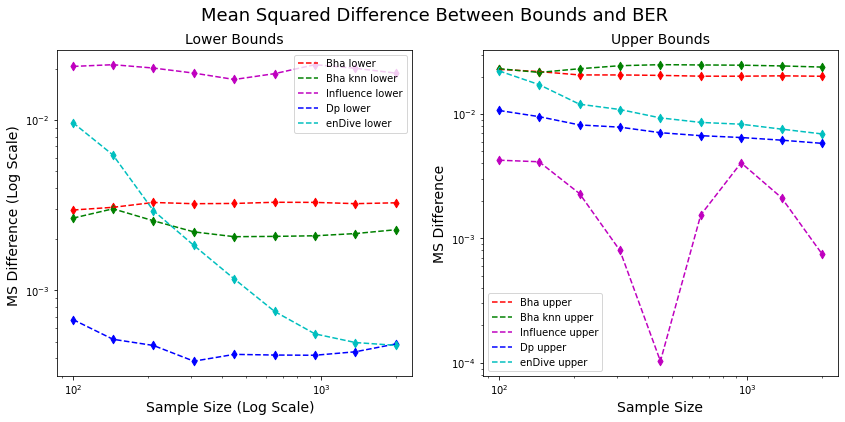

In [15]:
lower_mse_DP =mse_v2(BER, dp_l)
upper_mse_DP = mse_v2(BER, dp_u)

lower_mse_Bha = mse_v2(BER, Bha_l)
upper_mse_Bha =mse_v2(BER, Bha_u)


lower_mse_Bha_knn = mse_v2(BER, Bha_knn_l)
upper_mse_Bha_knn =mse_v2(BER, Bha_knn_u)

lower_mse_inf = mse_v2(BER, inf_l)
upper_mse_inf = mse_v2(BER, inf_u)

lower_mse_enDive = mse_v2(BER, enDive_l)
upper_mse_enDive = mse_v2(BER, enDive_u)

fs =14

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
st = fig.suptitle("Mean Squared Difference Between Bounds and BER", fontsize=fs+4)
ax = axes[0]


ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, lower_mse_Bha,'r--', label='Bha lower')
ax.scatter(sample_sizes, lower_mse_Bha, color = 'red', marker = 'd')

ax.plot(sample_sizes, lower_mse_Bha_knn, color = 'green',linestyle="--",  label = "Bha knn lower")
ax.scatter(sample_sizes, lower_mse_Bha_knn, color = 'g', marker = 'd')

ax.plot(sample_sizes, lower_mse_inf,  'm--', label='Influence lower')
ax.scatter(sample_sizes, lower_mse_inf,  color='m', marker='d')

ax.plot(sample_sizes, lower_mse_DP,  'b--', label='Dp lower')
ax.scatter(sample_sizes, lower_mse_DP,  color='b', marker='d')


ax.plot(sample_sizes, lower_mse_enDive,  'c--', label='enDive lower')
ax.scatter(sample_sizes, lower_mse_enDive,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale) ", fontsize=fs)
ax.set_title("Lower Bounds", fontsize = fs)


ax.legend()

ax = axes[1]

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, upper_mse_Bha,'r--', label='Bha upper')
ax.scatter(sample_sizes, upper_mse_Bha, color = 'red', marker = 'd')


ax.plot(sample_sizes, upper_mse_Bha_knn, color = 'g',  linestyle  = "--", label = "Bha knn upper")
ax.scatter(sample_sizes, upper_mse_Bha_knn, color = 'g', marker = 'd')

ax.plot(sample_sizes, upper_mse_inf,  'm--', label='Influence upper')
ax.scatter(sample_sizes, upper_mse_inf,  color='m', marker='d')


ax.plot(sample_sizes, upper_mse_DP,  'b--', label='Dp upper')
ax.scatter(sample_sizes, upper_mse_DP,  color='b', marker='d')


ax.plot(sample_sizes, upper_mse_enDive,  'c--', label='enDive upper')
ax.scatter(sample_sizes, upper_mse_enDive,  color='c', marker='d')

ax.set_xlabel("Sample Size", fontsize = fs)
ax.set_ylabel("MS Difference", fontsize=fs)
ax.set_title("Upper Bounds", fontsize = fs )

ax.legend()

# plt.savefig("log_test.png",facecolor=(1,1,1,1))
# ax.set_xticks(sample_sizes)

file_name = r"alt_distr/images/uniform_normal_2.png"
plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= 600)
plt.show()

Bhattacharyya, Bha Knn, influence same theoretically

Dp, enDive

In [16]:
BER

0.15350691875939732

In [17]:
lst = [obj.validity(BER) for obj in bound_obj_lst ]

df_valid = pd.DataFrame(lst, index = sample_sizes)

df_valid


,Dp_lower,Dp_upper,Bha_lower,Bha_upper,Bha_knn_lower,Bha_knn_upper,tight_lower,tight_upper,Maha_upper,inf_lower,inf_upper,enDive_lower,enDive_upper
100,0.5775,0.9975,0.9875,1.0,1.0,1.0,NaN,NaN,NaN,1.0,0.0325,0.5525,0.7825
145,0.6950,1.0000,0.9950,1.0,1.0,1.0,NaN,NaN,NaN,1.0,0.0000,0.5950,0.8250
211,0.7800,1.0000,1.0000,1.0,1.0,1.0,NaN,NaN,NaN,1.0,0.0000,0.6550,0.8875
307,0.8350,1.0000,1.0000,1.0,1.0,1.0,NaN,NaN,NaN,1.0,0.0000,0.6200,0.9375
447,0.9100,1.0000,1.0000,1.0,1.0,1.0,NaN,NaN,NaN,1.0,0.1625,0.7075,0.9750
650,0.9625,1.0000,1.0000,1.0,1.0,1.0,NaN,NaN,NaN,1.0,0.1925,0.7225,0.9975
945,0.9875,1.0000,1.0000,1.0,1.0,1.0,NaN,NaN,NaN,1.0,0.0000,0.7725,1.0000
1375,0.9975,1.0000,1.0000,1.0,1.0,1.0,NaN,NaN,NaN,1.0,0.0000,0.8525,1.0000
2000,1.0000,1.0000,1.0000,1.0,1.0,1.0,NaN,NaN,NaN,1.0,0.0000,0.9100,1.0000


In [18]:
def add_noise_to_df(df, noise_level=0.01):
    """
    Add random noise to each column in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing the data to which noise will be added.
    
    Returns:
    - pandas DataFrame with noise added to each column.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_noisy = df.copy()
    
    # Iterate through each column in the DataFrame
    for col in df.columns:
        # Calculate the range of the data in the column
#         data_range = df[col].max() - df[col].min()
        
        # Generate random noise from a normal distribution
#         noise = np.random.normal(0, noise_level * data_range, len(df[col]))
        noise = np.random.normal(0, noise_level )
#         noise = np.random.uniform(-1 * noise_level, noise_level)
        # Add the noise to the data in the column
        df_noisy[col] = df[col] + noise
    
    return df_noisy


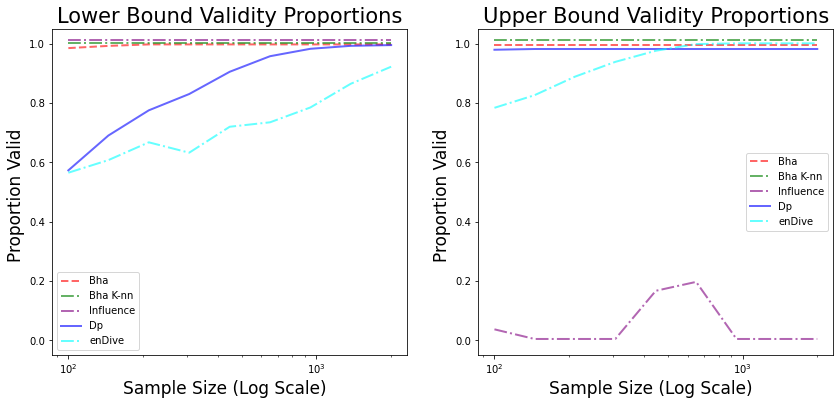

In [19]:
df_noise = add_noise_to_df(df_valid, .008)

fs =17
overlapping = 0.6
lw = 2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax = axes[0]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(df_noise["Bha_lower"],'r--', label='Bha', alpha = overlapping, linewidth=lw )

ax.plot(df_noise["Bha_knn_lower"],'g-.', label='Bha K-nn', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["inf_lower"],'purple',ls = "-.", label='Influence', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["Dp_lower"], 'b-',  label='Dp', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["enDive_lower"],'cyan',ls = "-.", label='enDive', alpha = overlapping, linewidth = lw)


# ax.plot(df_valid["tight_lower"],'orange', label='Tight  ')


# ax.plot(sample_sizes, validity_tight_u/ MC_num,  label='Upper Tight Validity ')
# ax.set_xticks(sample_sizes)
ax.set_ylim(-0.05,1.05)
ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion Valid ", fontsize=fs)
ax.set_title("Lower Bound Validity Proportions" , fontsize = fs +4)
ax.legend()


ax = axes[1]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(df_noise["Bha_upper"],'r--', label='Bha', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["Bha_knn_upper"],'g-.', label='Bha K-nn', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["inf_upper"],'purple',ls = "-.", label='Influence', alpha = overlapping, linewidth =lw)

ax.plot(df_noise["Dp_upper"], 'b-',  label='Dp', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["enDive_upper"],'cyan',ls = "-.", label='enDive', alpha = overlapping, linewidth = lw)


# ax.set_xticks(sample_sizes)
ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion Valid ", fontsize=fs)
ax.set_ylim(-0.05,1.05)
ax.set_title("Upper Bound Validity Proportions" , fontsize = fs +4)
ax.legend()

# plt.subplots_adjust(left=0.05, right=0.96, bottom=0.1, top=0.90)


file_name = r"alt_distr/images/uniform_normal_3.png"
plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= 600)
plt.show()